# Logistic Regression — Breast Cancer Dataset
**Goal:** Predict whether a tumor is malignant (1) or benign (0) using the Wisconsin Breast Cancer dataset from scikit-learn.

**Sections:**
1. Load & Explore Data
2. Preprocessing
3. Train the Model
4. Evaluation Metrics

## 1. Load & Explore Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # 0 = malignant, 1 = benign

print('Shape:', df.shape)
print('\nClass distribution:')
print(df['target'].value_counts().rename({0: 'Malignant', 1: 'Benign'}))

Shape: (569, 31)

Class distribution:
target
Benign       357
Malignant    212
Name: count, dtype: int64


In [3]:
df.describe().T[['mean', 'std', 'min', 'max']].head(10)

,mean,std,min,max
mean radius,14.127292,3.524049,6.98100,28.11000
mean texture,19.289649,4.301036,9.71000,39.28000
mean perimeter,91.969033,24.298981,43.79000,188.50000
mean area,654.889104,351.914129,143.50000,2501.00000
mean smoothness,0.096360,0.014064,0.05263,0.16340
mean compactness,0.104341,0.052813,0.01938,0.34540
mean concavity,0.088799,0.079720,0.00000,0.42680
mean concave points,0.048919,0.038803,0.00000,0.20120
mean symmetry,0.181162,0.027414,0.10600,0.30400
mean fractal dimension,0.062798,0.007060,0.04996,0.09744


In [4]:
# Check for missing values
print('Missing values:', df.isnull().sum().sum())

Missing values: 0


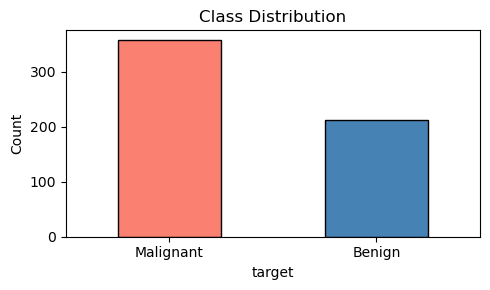

In [5]:
# Class distribution plot
fig, ax = plt.subplots(figsize=(5, 3))
df['target'].value_counts().rename({0: 'Malignant', 1: 'Benign'}).plot(kind='bar', ax=ax, color=['salmon', 'steelblue'], edgecolor='black')
ax.set_title('Class Distribution')
ax.set_ylabel('Count')
ax.set_xticklabels(['Malignant', 'Benign'], rotation=0)
plt.tight_layout()
plt.show()

## 2. Preprocessing

Logistic regression is sensitive to feature scale. We standardize features so each has mean=0 and std=1.

In [6]:
X = df.drop('target', axis=1)
y = df['target']

# Train/test split (80/20, stratified to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit only on training data!
X_test_scaled  = scaler.transform(X_test)

print(f'Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}')

Train size: 455 | Test size: 114


## 3. Train the Model

In [7]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]  # probability of benign

print('Model trained. Predictions generated.')

Model trained. Predictions generated.


## 4. Evaluation Metrics

### 4.1 Classification Report
Includes precision, recall, F1-score per class.

In [8]:
print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### 4.2 Confusion Matrix

- **True Positives (TP):** Correctly predicted benign
- **True Negatives (TN):** Correctly predicted malignant
- **False Positives (FP):** Predicted benign, actually malignant ← dangerous in medical context
- **False Negatives (FN):** Predicted malignant, actually benign

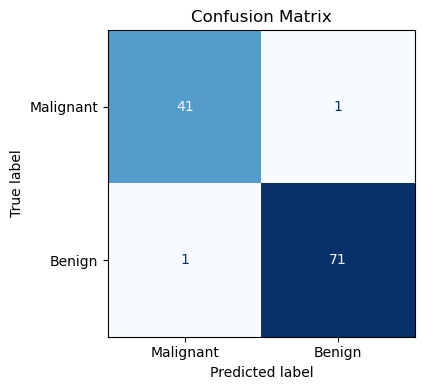

In [9]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Malignant', 'Benign'])

fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

### 4.3 ROC Curve & AUC

The ROC curve plots the trade-off between True Positive Rate and False Positive Rate across all thresholds. AUC = 1.0 is perfect; 0.5 is random.

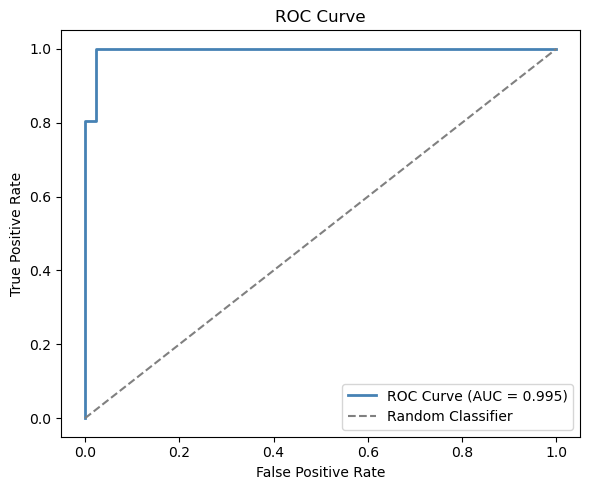

AUC: 0.9954


In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(fpr, tpr, color='steelblue', lw=2, label=f'ROC Curve (AUC = {auc:.3f})')
ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f'AUC: {auc:.4f}')

### 4.4 Top Feature Coefficients

In logistic regression, the coefficients tell you how much each feature pushes the prediction toward benign (positive) or malignant (negative).

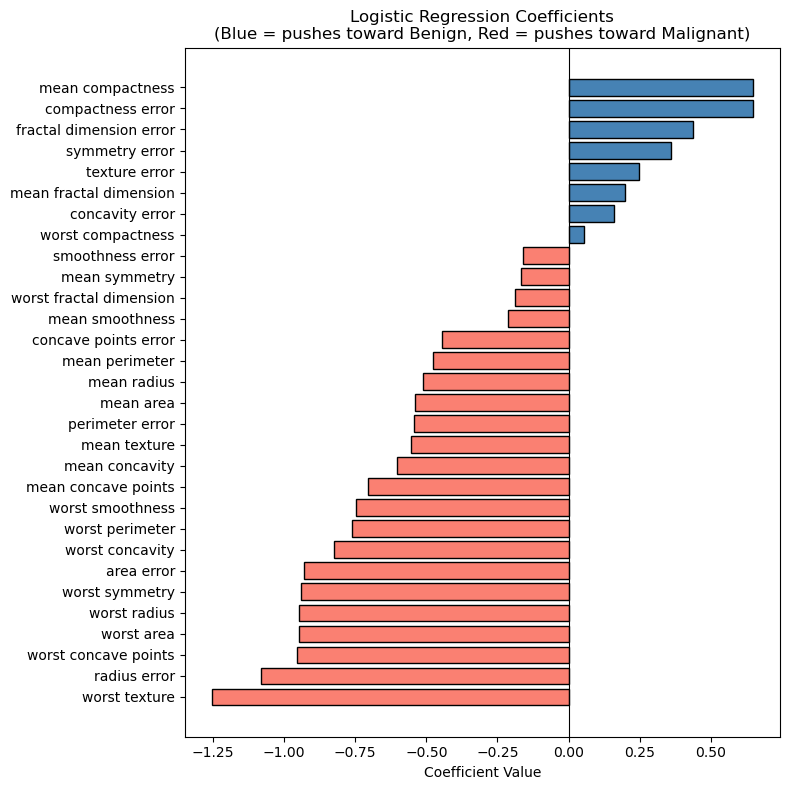

In [11]:
coef_df = pd.DataFrame({
    'Feature': data.feature_names,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient')

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['salmon' if c < 0 else 'steelblue' for c in coef_df['Coefficient']]
ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='black')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('Logistic Regression Coefficients\n(Blue = pushes toward Benign, Red = pushes toward Malignant)')
ax.set_xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

## Summary

| Metric | Value |
|---|---|
| Accuracy | See classification report |
| AUC | See ROC curve output |
| False Positives | See confusion matrix |

**Key takeaways:**
- Logistic regression performs very well on this dataset — it's well-suited for linearly separable problems.
- In a medical context, **recall for malignant cases** (minimizing false negatives) is more important than raw accuracy.
- Features with large positive coefficients are strong predictors of benign tumors; large negative ones indicate malignancy.